# Quantum Simulation

## Import section

In [1]:
# Python Libraries
import numpy as np
from numpy import linalg
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time
from math import pi
import scipy

from qiskit import *
from qiskit_aer import QasmSimulator, UnitarySimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime import *

#from qiskit_opflow import X, Y, Z, I
from qiskit.quantum_info import Pauli
#from qiskit.quantum_info import process_fidelity

# Qiskit Aer
#from qiskit.quantum_info import Kraus, SuperOp
#from qiskit.providers.aer import QasmSimulator
#from qiskit.providers.aer.noise import NoiseModel
#from qiskit.providers.aer.noise import QuantumError, ReadoutError
#from qiskit.providers.aer.noise import pauli_error
#from qiskit.providers.aer.noise import depolarizing_error
#from qiskit.providers.aer.noise import thermal_relaxation_error
#from qiskit.providers.models import BackendProperties
#from qiskit.providers.aer import noise

print('Import successful')

Import successful


In [14]:
Pauli('X').to_matrix()

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

# Transverse-field Ising model
### $\mathcal{H} = b (s_{x1}+s_{x2}) + J s_{z1}s_{z2} = \frac{b}{2} (X_1 + X_2) + \frac{J}{4} Z_1 Z_2 $

## Suzuki-Trotter decomposition

In [24]:
b = 1;
J = 2;
Ntime = 100; 
Ntr = 5;

X1 = Pauli('XI').to_matrix();
X2 = Pauli('IX').to_matrix();
Z1 = Pauli('ZI').to_matrix();
Z2 = Pauli('IZ').to_matrix();
ZZ = Pauli('ZZ').to_matrix();

H1 = b*(X1+X2)/2;
H2 = J*ZZ/4;
Ham = H1 + H2;

Mz = (Z1+Z2)/2

time = np.linspace(0,4*pi,Ntime)

psi0 = np.array([1,0,0,0])

Mzt = []
Mzt_T = []

for it in range(Ntime):
    
    psi = np.dot(scipy.linalg.expm(-Ham*time[it]*1j),psi0)
    Mzt.append( np.real(np.dot(np.conj(psi),np.dot(Mz,psi))))
    
    exp1 = scipy.linalg.expm(-H1*time[it]*1j/Ntr);
    exp2 = scipy.linalg.expm(-H2*time[it]*1j/Ntr);
    
    psi_T = np.dot(np.linalg.matrix_power(np.dot(exp1,exp2),Ntr),psi0)
    Mzt_T.append(np.real( np.dot(np.conj(psi_T),np.dot(Mz,psi_T))))


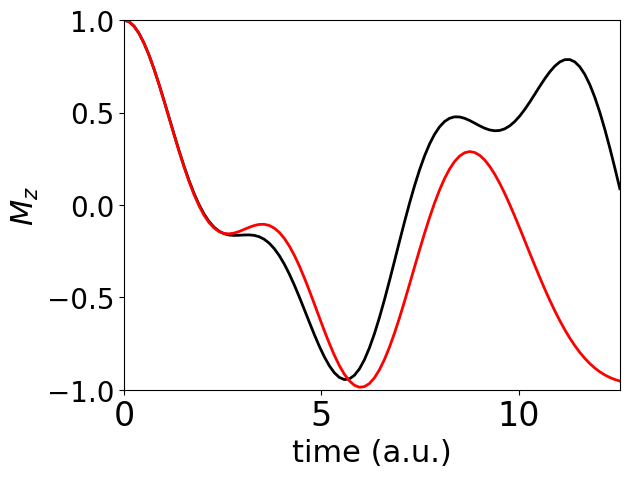

In [25]:
# plot results

fig, ax = plt.subplots()

plt.plot(time, Mzt, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("$M_z$",size=22)

plt.ylim([-1,1])
plt.xlim([0,4*pi])

plt.plot(time, Mzt_T, linewidth=2.0, color = 'r')

### Gate decomposition

##### one-body ($X_{1,2}$) terms correspond to Rx single qubit rotations
##### two-body ZZ term can be simulated by CX, Rz(2phi), CX

In [32]:
time_sim = np.linspace(0, 4*pi, 20)

Nshots = 8192

backend = QasmSimulator()

Mz_sim = []
for it in range(len(time_sim)):
    
    qc = QuantumCircuit(2,2)
    
    for itr in range(Ntr):
        
        qc.rx(b*time_sim[it]/Ntr,0)
        qc.rx(b*time_sim[it]/Ntr,1)
        qc.barrier()
        
        qc.cx(0,1)
        qc.rz(2*J*time_sim[it]/Ntr/4,1)
        qc.cx(0,1)
        
    qc.measure(0,0)
    qc.measure(1,1)

    counts = backend.run(qc.decompose(), shots= Nshots).result().get_counts()
       
    if not "00" in counts: counts["00"] = 0
    if not "01" in counts: counts["01"] = 0
    if not "10" in counts: counts["10"] = 0
    if not "11" in counts: counts["11"] = 0
        
    Mz_sim.append( (counts['00']-counts['11'])/Nshots )

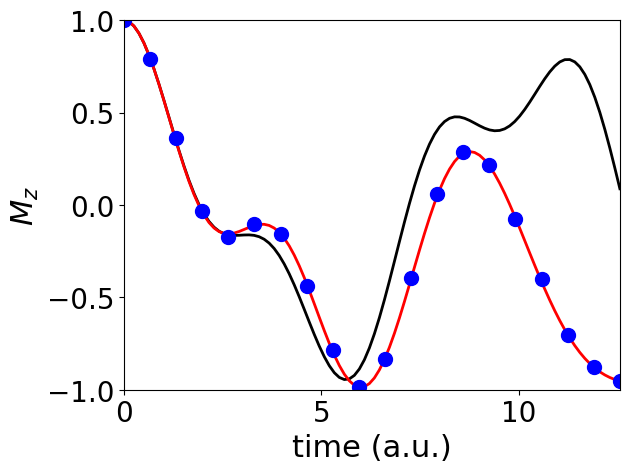

In [33]:
# plot results

fig, ax = plt.subplots()

plt.plot(time, Mzt, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("$M_z$",size=22)

plt.ylim([-1,1])
plt.xlim([0,4*pi])

plt.plot(time, Mzt_T, linewidth=2.0, color = 'r')

plt.plot(time_sim, Mz_sim, color='b', lw=0, marker='o', markersize=10)


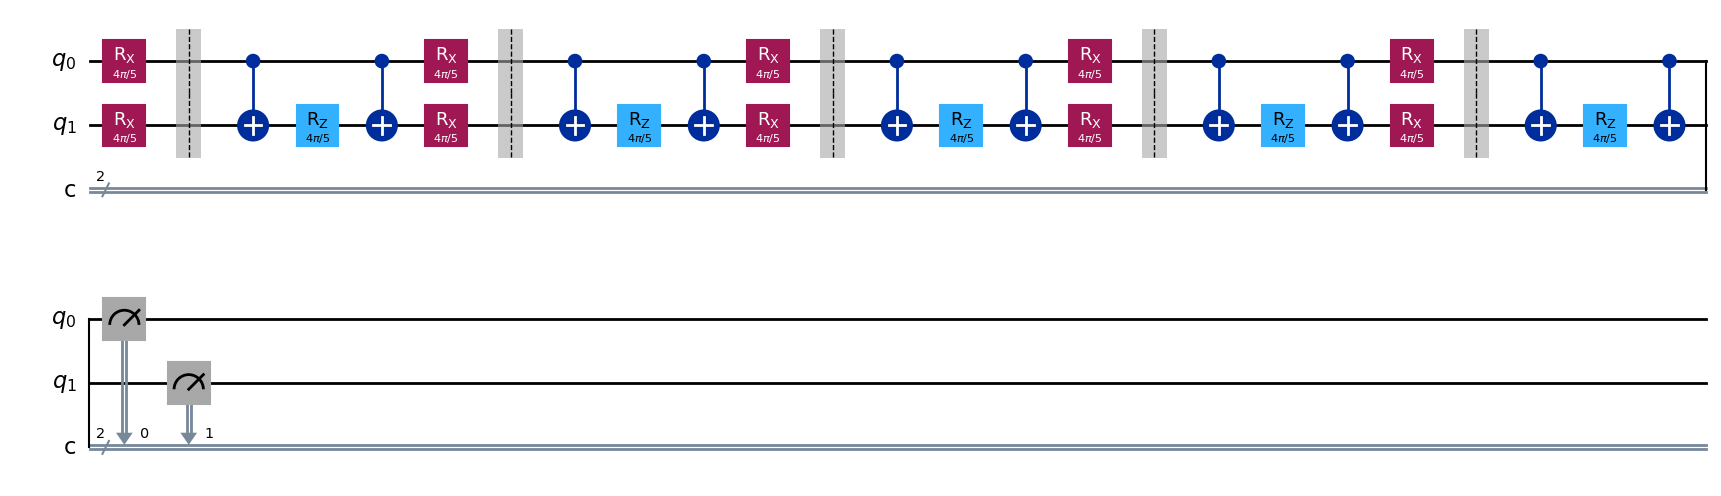

In [34]:
qc.draw('mpl')

### Compute dynamical correlation functions $\langle s_{x1}(t)s_{x2} \rangle = \langle \psi | X_1(t) X_2 | \psi \rangle/4$

#### we need 3 qubits: q0 and q1 to simulate the target system, q2 = ancilla to measure correlation functions

In [42]:
b = 1;
J = 2;
Ntime = 100; 
Ntr = 5;

X1 = Pauli('XI').to_matrix();
X2 = Pauli('IX').to_matrix();
Z1 = Pauli('ZI').to_matrix();
Z2 = Pauli('IZ').to_matrix();
ZZ = Pauli('ZZ').to_matrix();

H1 = b*(X1+X2)/2;
H2 = J*ZZ/4;
Ham = H1 + H2;

time = np.linspace(0,4*pi,Ntime)

psi0 = np.array([1,0,0,0])

XX_exact = []
XX_T = []

for it in range(Ntime):
    
    expT = scipy.linalg.expm(-Ham*time[it]*1j)
    expTt = scipy.linalg.expm(Ham*time[it]*1j)
    exp1 = scipy.linalg.expm(-H1*time[it]*1j/Ntr);
    exp2 = scipy.linalg.expm(-H2*time[it]*1j/Ntr);
    exp1t = scipy.linalg.expm(H1*time[it]*1j/Ntr);
    exp2t = scipy.linalg.expm(H2*time[it]*1j/Ntr);
    
    XX_exact.append( np.dot(psi0,np.dot(np.dot(np.dot(np.dot( expTt,X1  ), expT),X2),psi0)))
    
    exp_trot = np.linalg.matrix_power(np.dot(exp2,exp1),Ntr)
    exp_trotT = np.linalg.matrix_power(np.dot(exp1t,exp2t),Ntr)              
    
    XX_T.append( np.dot(psi0,np.dot(np.dot(np.dot(np.dot( exp_trotT,X1  ), exp_trot),X2),psi0)))

### Circuit

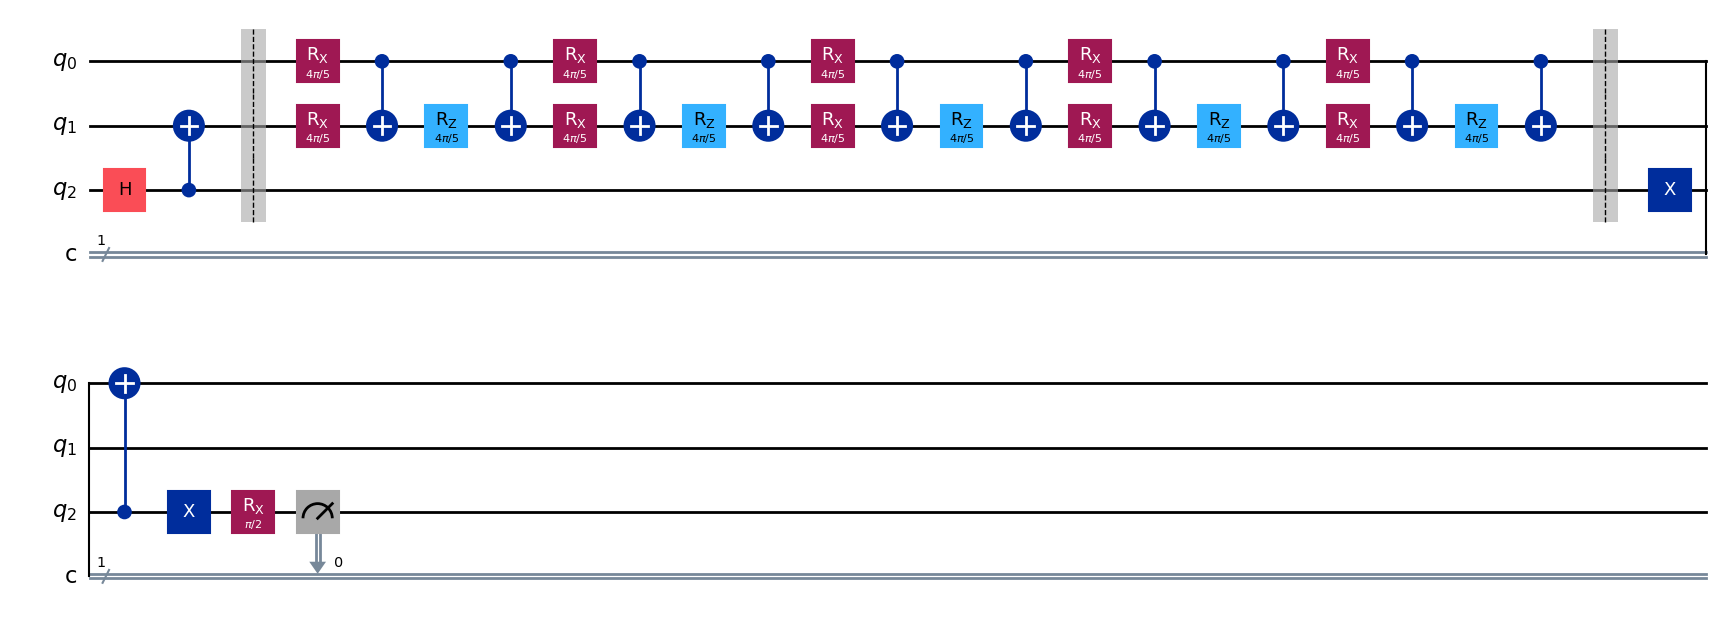

In [39]:
time_sim = np.linspace(0, 4*pi, 10)

backend = QasmSimulator()
Nshots = 8192

XX_real_sim = []
for it in range(len(time_sim)):
    
    qc = QuantumCircuit(3,1)
    
    qc.h(2)  # ancilla
    qc.cx(2,1) # ancilla = control
    qc.barrier()
    for itr in range(Ntr):
        
        qc.rx(b*time_sim[it]/Ntr,0)
        qc.rx(b*time_sim[it]/Ntr,1)
        
        qc.cx(0,1)
        qc.rz(2*J*time_sim[it]/Ntr/4,1)
        qc.cx(0,1)
        
    qc.x(2)
    qc.cx(2,0)
    qc.x(2)

    qc.barrier()
    qc.h(2)  # to get real part of the correlation function
    
    qc.measure(2,0)
    
    counts = backend.run(qc.decompose(), shots= Nshots).result().get_counts()
    
    if not "0" in counts: counts["0"] = 0
    if not "1" in counts: counts["1"] = 0
        
    XX_real_sim.append( (counts['0']-counts['1'])/Nshots/4 )
    
XX_imag_sim = []
for it in range(len(time_sim)):
    
    qc = QuantumCircuit(3,1)
    
    qc.h(2)  # ancilla
    qc.cx(2,1) # ancilla = control
    qc.barrier()
    for itr in range(Ntr):
        
        qc.rx(b*time_sim[it]/Ntr,0)
        qc.rx(b*time_sim[it]/Ntr,1)
        
        qc.cx(0,1)
        qc.rz(2*J*time_sim[it]/Ntr/4,1)
        qc.cx(0,1)

    qc.barrier()
    qc.x(2)
    qc.cx(2,0)
    qc.x(2)
    
    qc.rx(pi/2,2)  # to get real part of the correlation function
    
    qc.measure(2,0)
    
    counts = backend.run(qc.decompose(), shots= Nshots).result().get_counts()
    
    if not "0" in counts: counts["0"] = 0
    if not "1" in counts: counts["1"] = 0
        
    XX_imag_sim.append( (counts['0']-counts['1'])/Nshots/4 )
    
qc.draw('mpl')

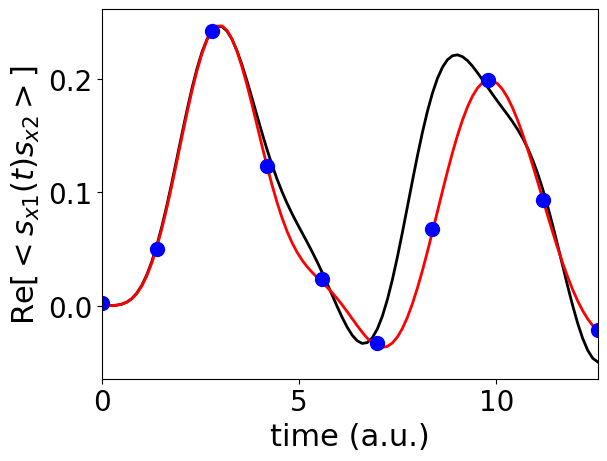

In [46]:
# plot results

fig, ax = plt.subplots()

plt.plot(time, np.real(XX_exact)/4, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("Re$[< s_{x1}(t) s_{x2} >]$",size=22)

#plt.ylim([-0.3,0.3])
plt.xlim([0,4*pi])

plt.plot(time, np.real(XX_T)/4, linewidth=2.0, color = 'r')

plt.plot(time_sim, XX_real_sim, color='b', lw=0, marker='o', markersize=10)

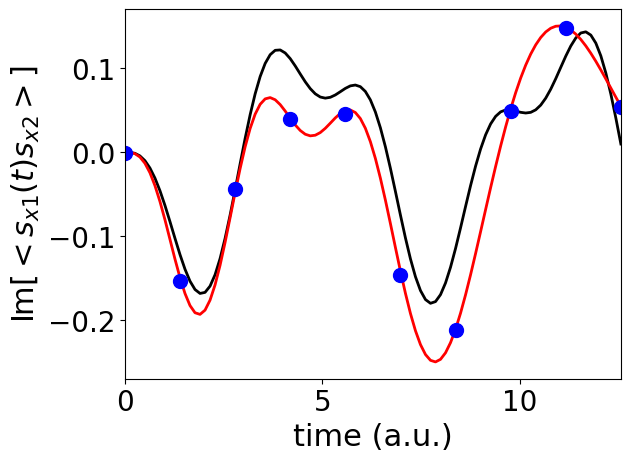

In [47]:

fig, ax = plt.subplots()

plt.plot(time, np.imag(XX_exact)/4, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("Im$[< s_{x1}(t) s_{x2} >]$",size=22)

#plt.ylim([-0.3,0.3])
plt.xlim([0,4*pi])

plt.plot(time, np.imag(XX_T)/4, linewidth=2.0, color = 'r')

plt.plot(time_sim, XX_imag_sim, color='b', lw=0, marker='o', markersize=10)